# RECEPTOR
- Codigo Fuente de Receptor.ipynb
- Autor:  Uberti, Ulises Leandro
- Asignatura: Señales Electricas
- Año: 2025

# Librerias y funciones necesarias

In [485]:
#Importamos las librerias necesarias 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import wave

#Subimos de nivel la carpeta para importar las funciones de otros archivos 
import sys 
sys.path.append("..")

#Importamos las funciones de otros archivos 
from modules.caracteristicas import Audio_Caracteristicas,Audio_FFT,Audio_Grafica
from scipy.signal import resample_poly
from scipy.io import wavfile
from modules.codificar import Codificar_Senial
from scipy.signal import butter, filtfilt


# Archivo con señal moduladala

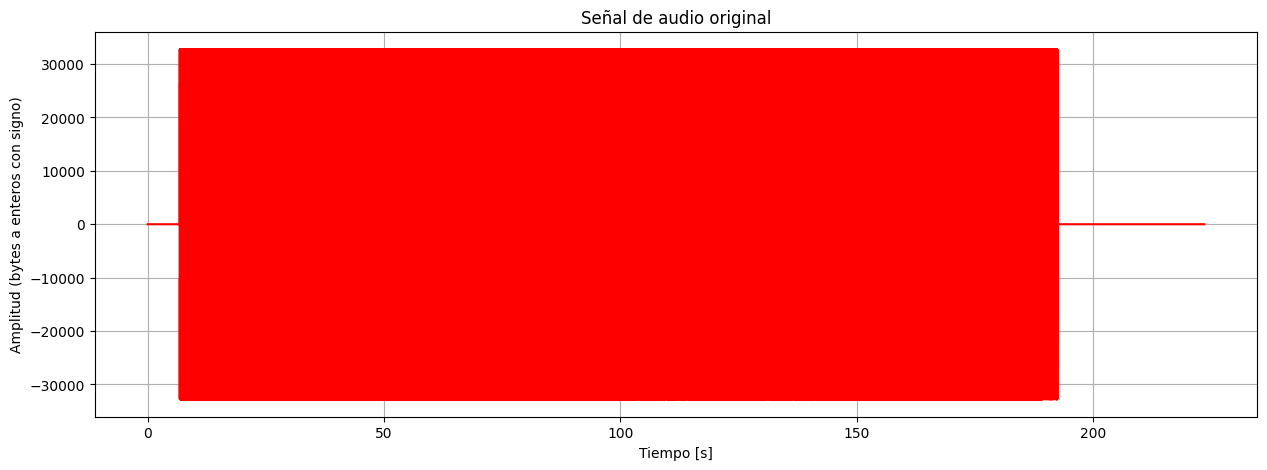

Canales: 1
Bits por muestra: 16
Frecuencia de muestreo: 50000 Hz
Duración: 223.50 segundos
La cantidad de meustras en la señal modulada debe ser igual que en el transmisor: 11175200


In [486]:
# Importamos el archivo con la señal modulada 
ruta = "Senial_OOK_1000_Sincronizada.wav"
Senial_OOK,t_Senial_OOK = Audio_Grafica(ruta)
canales,bits,fs,muestras,duracion=Audio_Caracteristicas(ruta)
print("La cantidad de meustras en la señal modulada debe ser igual que en el transmisor:",muestras)

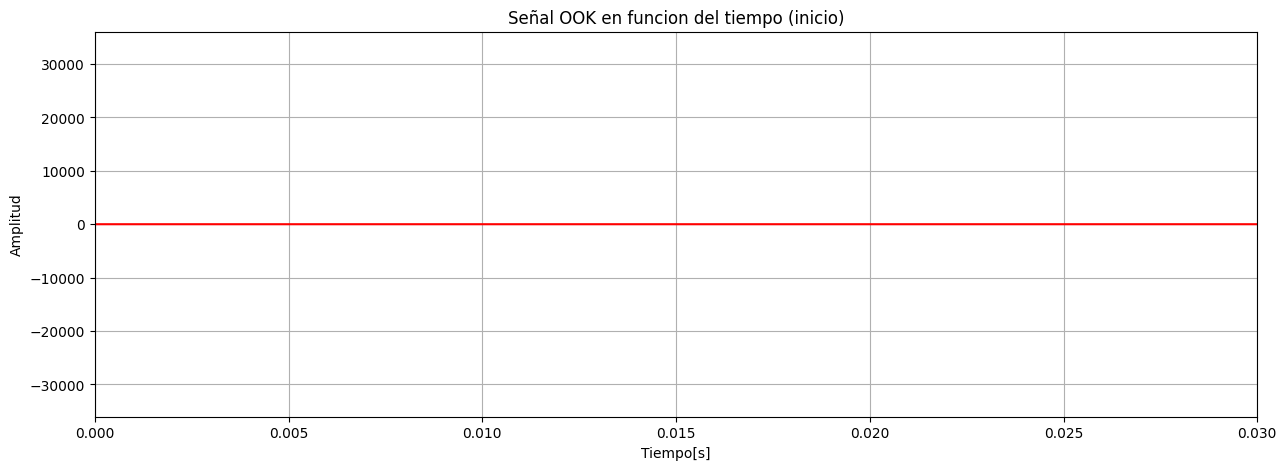

In [487]:
# Graficamos la señal modulada e el inicio para ver la sincronizacion (en este caso particular)
plt.figure(figsize=(15,5))
plt.plot(t_Senial_OOK,Senial_OOK,'r')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud")
plt.title("Señal OOK en funcion del tiempo (inicio)")
plt.grid(True)
plt.xlim(0,0.03)
plt.show()

# Demodulacion
En la practica demodulariamos con un dectector de envolvente, que consta de rectificar la señal y filtrarla 

Se tratara de realizar lo mismo por software 

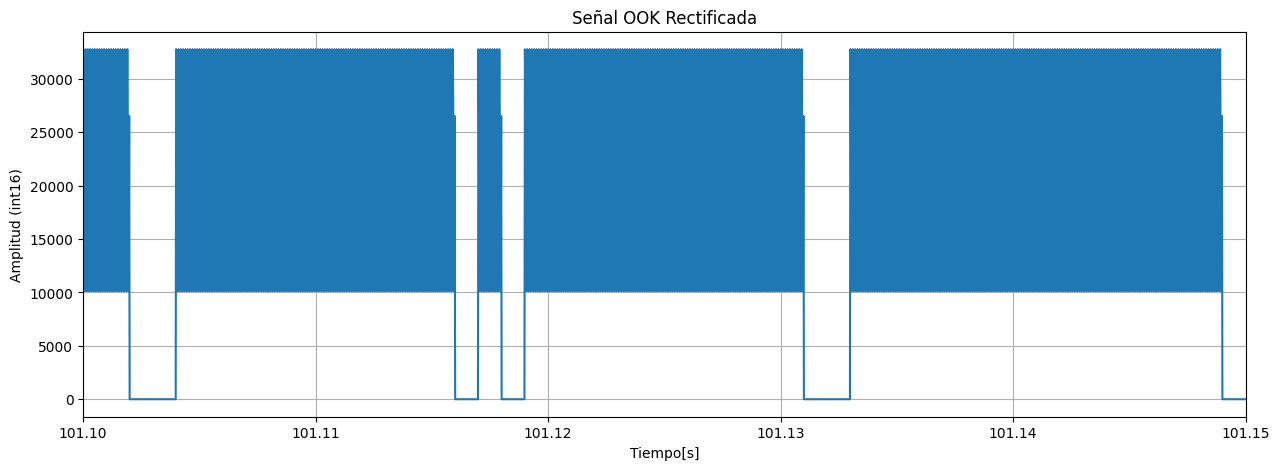

In [488]:
# Rectificamos la señal
Senial_OOK_Rectificada = np.abs(Senial_OOK)

#Graficamos la señal rectificada 
plt.figure(figsize=(15,5))
plt.plot(t_Senial_OOK,Senial_OOK_Rectificada)
plt.title("Señal OOK Rectificada")
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud (int16)")
plt.grid(True)
plt.xlim(101.1,101.15)
plt.show()

In [489]:
print("Cantidad de elementos en la señal rectificada:",len(Senial_OOK_Rectificada))

Cantidad de elementos en la señal rectificada: 11175200


C:\Users\MI PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


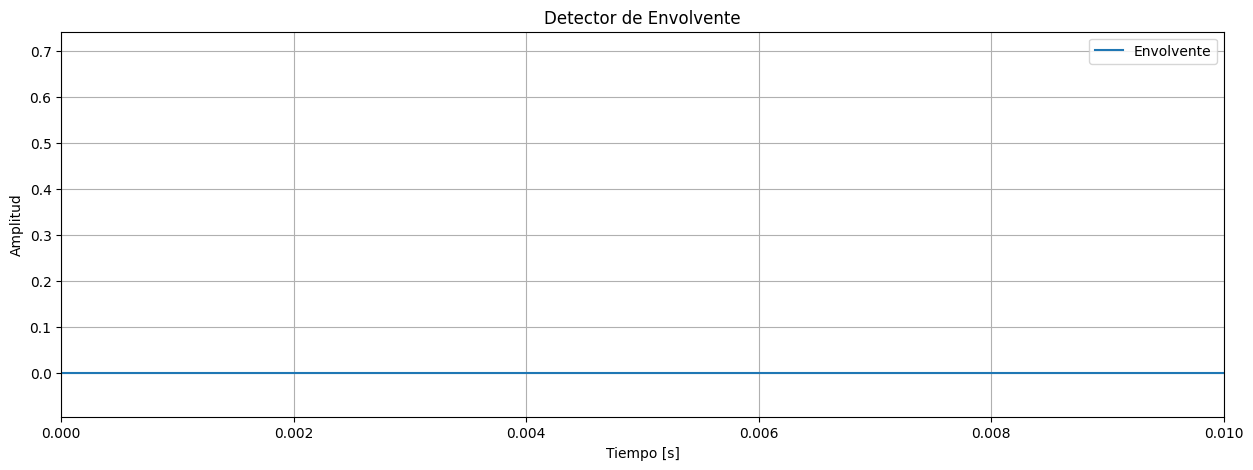

In [490]:
# convertimos en numeros de punto flotante (signo,exponente,mantisa)
Senial_OOK_Rectificada = Senial_OOK_Rectificada.astype(np.float16)
# normalizamos la señal dividiendo en el numero maximo del arreglo 
Senial_OOK_Rectificada /= np.max(Senial_OOK_Rectificada)
#filtramos (FPB)
#fs = 50000 #[Hz] frecuencia de muestreo de la señal en el transmisor 
fc_audio = 3000 # banda de guarda 
# filtro del tipo Butterworth de orden 8 y del tipo pasa-bajo 
b,a = butter(N=8,Wn=fc_audio/(fs/2),btype='low')
envolvente = filtfilt(b,a,Senial_OOK_Rectificada)

# Graficamos
t = np.arange(len(Senial_OOK)) / fs

plt.figure(figsize=(15,5))
plt.plot(t, envolvente, label='Envolvente')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Detector de Envolvente")
plt.xlim(0,0.01)
plt.legend()
plt.grid(True)
plt.show()


In [491]:
print("Cantidad de elementos en la envolvente:",len(envolvente))

Cantidad de elementos en la envolvente: 11175200


In [492]:
# Determinamos el valor umbral del comparador
umbral = np.mean(envolvente)
print("El valor medio de la envolvente es: ",np.round(umbral,4))

El valor medio de la envolvente es:  0.2589


C:\Users\MI PC\AppData\Local\Temp\ipykernel_10540\3689101624.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


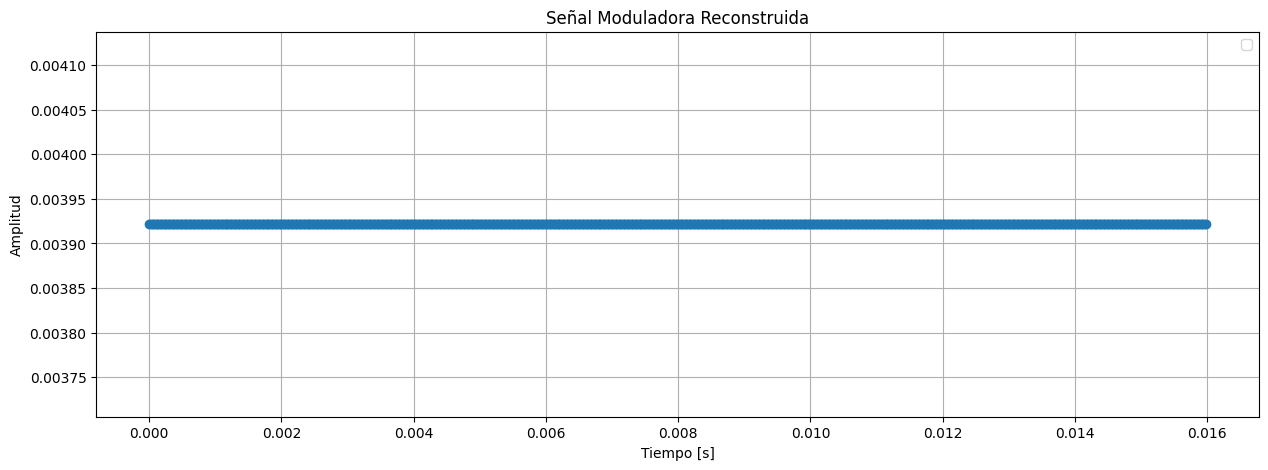

Duracion de Señal reconstruida  223.504


In [493]:
# comparador
senial_reconstruida = (envolvente > umbral).astype(np.uint8)  
senal_digital_audio = (senial_reconstruida * 2 - 1) * 255  
senal_digital_audio = senal_digital_audio.astype(np.int16)

# Graficamos
t_reconstruida = np.arange(len(senal_digital_audio)) / fs
plt.figure(figsize=(15,5))
plt.plot(t_reconstruida[:800], (senal_digital_audio/255)[:800],'-o', linewidth=1)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal Moduladora Reconstruida")
plt.legend()
plt.grid(True)
plt.show()
print("Duracion de Señal reconstruida ",len(senal_digital_audio)/fs)


In [494]:
print("Cantidad de elementos en la señal reconstruida:",len(senial_reconstruida))

Cantidad de elementos en la señal reconstruida: 11175200


In [495]:
# Convertimos la señal reconstruida en un arreglo de bits 

bits_array = []                       # arreglo que contendra los bits de la señal 
contador = 1                          # Contador para el bucle
muestra_actual=senial_reconstruida[0] #variable para llevar el bit
muestras_por_bit = 50                 # Cantidad de muestras por bit --> Sale de conocer "Rb" y "fs" del Tx (Tb*fs)
margen=2                              #bits , margen de error entre bits adyacentes 

In [496]:
# Recorremos el arreglo para distinguir el conjunto de 1s y 0s
for i in range(1,len(senial_reconstruida)):
    if muestra_actual==senial_reconstruida[i]:
        contador+=1
        if contador == 50:
            contador=0
            #muestra_actual=senial_reconstruida[i]
            bits_array.append(muestra_actual)
    else:
        if contador >= (muestras_por_bit-margen):
            bits_array.append(muestra_actual)
            contador=margen
            muestra_actual=senial_reconstruida[i]
            #contador=1
    muestra_actual=senial_reconstruida[i]

#Control del ultimo conjunto de muestras 
if (muestras_por_bit-margen)<= contador <=(muestras_por_bit+margen):
        bits_array.append(muestra_actual)
print("Cantidad de bits total:", len(bits_array))  
print("Primeros elementos del arreglo:",np.array(bits_array[20000:20016],dtype=int))

Cantidad de bits total: 223504
Primeros elementos del arreglo: [0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1]


# Sincronizacion 
Para detectar donde comineza el mensaje se utiliza una palabra de sincronizacion, al detectarla comenzamos la recuperacion del mensaje

Antes de la palabra de sincronizacion no cuenta como parte del mensaje

In [497]:
# Necesitamos un codigo que indique el comienzo de la ventana de sincronizacion 
Sincron = np.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])  # Sincronizacion debe coincider en Tx y Rx
print("Cantidad de bits de sincronizacion: ",len(Sincron),", Arreglo de sincronizacion: ",Sincron)

Cantidad de bits de sincronizacion:  16 , Arreglo de sincronizacion:  [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


In [498]:
# Codigo para detectar la sincronizacion 
# Genero todas las ventanas del tamaño del bloque de sincronizacion  
ventanas = np.lib.stride_tricks.sliding_window_view(bits_array,len(Sincron))
# Busco la coincidencia 
Coincidencia = np.all(ventanas==Sincron,axis=1)
posiciones = np.where(Coincidencia)[0]
posicion = int(posiciones[0])
print(posicion)

40000


In [499]:
# Utilizamos condicionales para determinar si se detecto la coincidencia y el mensaje puede demodularse 
if np.array_equal(bits_array[posicion:posicion+16],Sincron):
    print("Mensaje Detectado: ")
    print("Posicion a partir de la cual se detecto la sincronizacion: ",posicion)
    Mensaje = np.array(bits_array[posicion+16:len(bits_array)]) 
    print("cantidad de elementos en el mensaje: ",len(Mensaje))
else:
    print("No se detecto un mensaje")

Mensaje Detectado: 
Posicion a partir de la cual se detecto la sincronizacion:  40000
cantidad de elementos en el mensaje:  183488


In [512]:
Cantidad_Palabras = int(len(Mensaje)/16)*16
print("Cantidad de palabras: ",Cantidad_Palabras)
Mensaje = Mensaje[:Cantidad_Palabras]
n=16 # cantidad de bits

Cantidad de palabras:  183488


In [513]:
# Reconstruimos las palabras con tamaño de 16 bits (caso por defecto tomado)
Mensaje_reshape = Mensaje.reshape(int(Cantidad_Palabras/n),n)
print("Cantidad de elementos en el arreglo: ",len(Mensaje_reshape))

Cantidad de elementos en el arreglo:  11468


In [502]:
# indicamos que el msb es el bit de signo
bin_weights = 1 << np.arange(15,-1,-1)
# Convertimos a enteros sin signo primero 
Mensaje_Unsigned = Mensaje_reshape.dot(bin_weights)
# Convertimos a enteros con signo 
Mensaje_Signed = Mensaje_Unsigned.astype(np.int16) 
print("La cantidad de elementos del arreglo final es: ",len(Mensaje_Signed))

La cantidad de elementos del arreglo final es:  11468


In [514]:
# Reconstruimos el eje de tiempos para la fs de 3000 Hz (debemos conocer la fs original del mensaje)
fs_original=3000 #[Hz] frecuencia del re-muestreo

t_audio_demodulada = np.arange(len(Mensaje_Signed))/fs_original
print(len(t_audio_demodulada))

11468


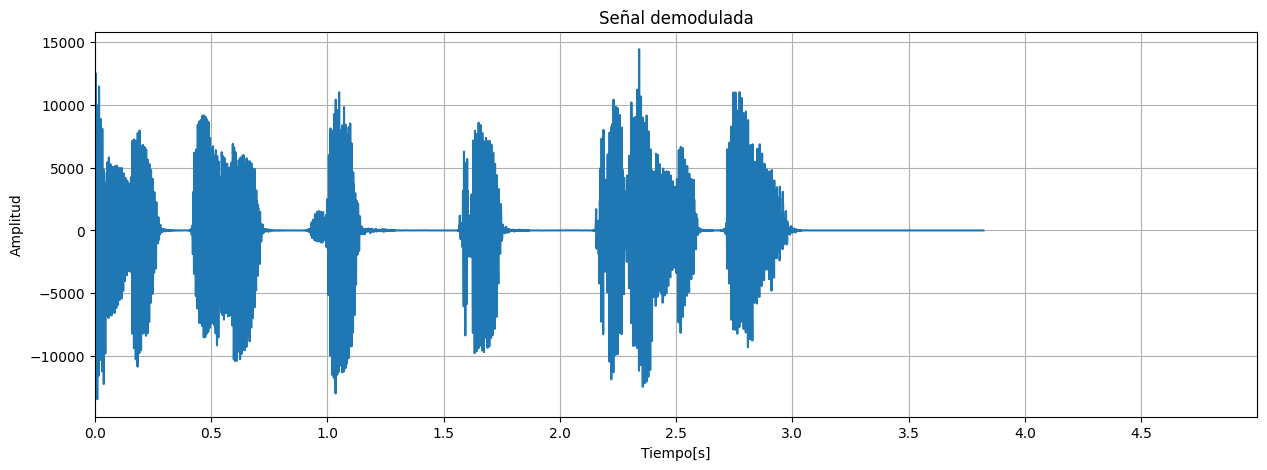

In [504]:
# Graficamos la señal de audio recuperada en funcion del tiempo
plt.figure(figsize=(15,5))
plt.plot(t_audio_demodulada,Mensaje_Signed)
plt.grid(True)
plt.title("Señal demodulada")
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud")
plt.xlim(0,5)
plt.xticks(np.arange(0,5,0.5))
plt.show()

# Archivo de la señal demodulada sincronizada

In [505]:
wavfile.write('Senial_Demodulada_Sincronizada.wav',fs_original,Mensaje_Signed)

# Desincronizado

In [515]:
# Volvemos al arreglo original de bits

#Cada x muestras determinamos si se trata de un "1" o "0" segun cuantas muestras por bits tengamos
init_sample = 25 #x
samples_per_bit = 50 #cantidad de muestras por bit
cant_bits = len(senial_reconstruida)// samples_per_bit # cantidad total de bits
print("Cantidad de bits del arreglo: ",cant_bits)

# Reconstruimos el arreglo de bits original 

# Gneramos un arreglo de "0" con el ancho necesario
bits_reshaped = np.zeros(cant_bits,dtype=int)
#recorremos el arreglo original y extraemos el valor de cada bit y lo agregamos en otro arreglo
for i in range(cant_bits):
    sample = i * samples_per_bit + init_sample
    bits_reshaped[i] = senial_reconstruida[sample]
# vemos si el arreglo resultante tiene igual ancho que el que se utilizo en el transmisor 
print("El ancho del arreglo reconstruido es: ",len(bits_reshaped))

Cantidad de bits del arreglo:  223504
El ancho del arreglo reconstruido es:  223504


In [516]:
#Convertimos el arreglo en un arreglo de listas de 16 elementos correspondientes a los 16 bits por muestra
senial_reshape = bits_reshaped.reshape(int(len(bits_reshaped)/16),16)
print("Cantidad de elementos en el arreglo, debe corresponderse con la cantidad de muestras de la señal original: ",len(senial_reshape))


Cantidad de elementos en el arreglo, debe corresponderse con la cantidad de muestras de la señal original:  13969


In [520]:
# indicamos que el msb es el bit de signo
bin_weights = 1 << np.arange(15,-1,-1)
#Convertimos a enteros sin signo primero 
int_unsigned = senial_reshape.dot(bin_weights)
# Convertimos a enteros con signo 
senial_int_signed_des = int_unsigned.astype(np.int16) 
print("La cantidad de elementos del arreglo final es: ",len(senial_int_signed_des))

La cantidad de elementos del arreglo final es:  13969


In [521]:
# Reconstruimos el eje de tiempos para la fs de 3000 Hz 
fs_original=3000 #[Hz] frecuencia del re-muestreo
Rb=1000 #[bps]
duracion_final = duracion/fs*Rb #[s]
t_audio_demodulada = np.linspace(0,duracion_final,num=(len(senial_int_signed_des)))

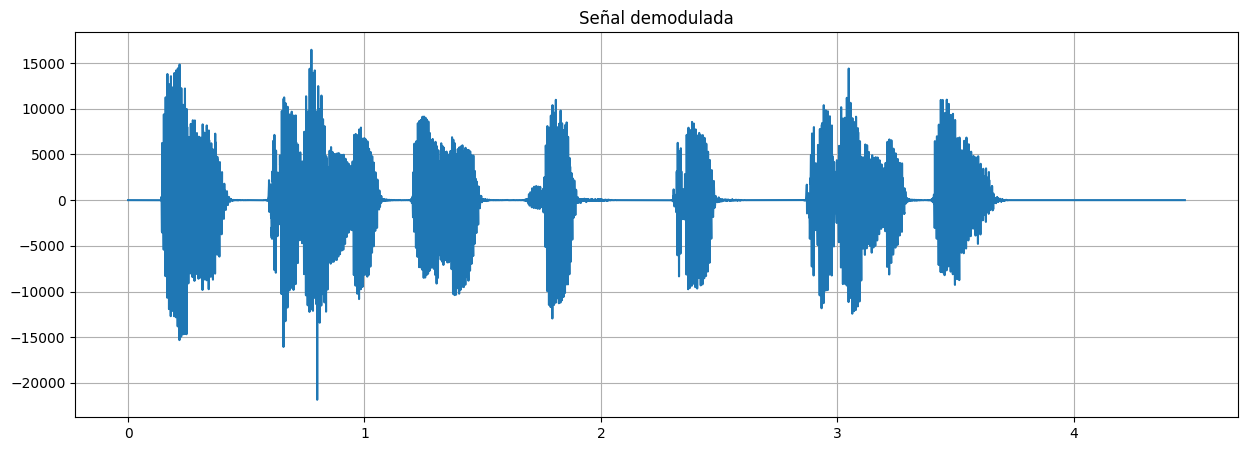

In [522]:
# Graficamos la señal de audio recuperada en funcion del tiempo
plt.figure(figsize=(15,5))
plt.plot(t_audio_demodulada,senial_int_signed_des)
plt.grid(True)
plt.title("Señal demodulada")
plt.show()

# Archivo de la señal de audio demodulada

In [523]:
wavfile.write('Senial_Demodulada_Desincronizada.wav',fs_original,senial_int_signed)